# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
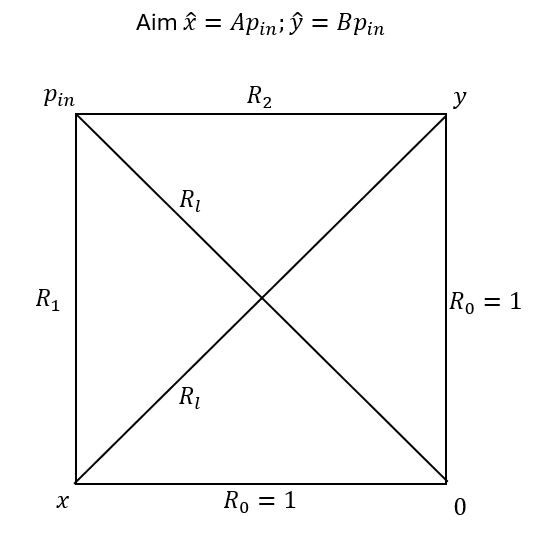
</div>


In [2]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.R_in_t = [np.array([1.,1.])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.out_clamped_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.out_clamped_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[-1][0],
#                                  syms.p2:self.p_in_t[-1][1], syms.Rl:2**(1/2)})
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[0][0],
#                                  syms.p2:self.p_in_t[0][1], syms.Rl:2**(1/2)})
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':
            # p_nxt = p - np.dot(state.variabs.alpha, loss) * self.t
            # p_nxt = p - np.dot(2*(1-np.e**-(state.variabs.alpha*self.t)), loss)
            # p_nxt = p - np.dot(self.variabs.alpha, loss*(1+self.bc_noise*pert))
            # p_nxt = p - np.dot(self.variabs.alpha, loss)       
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression':
            p_drawn = self.p_drawn_in_t[-1]
            p_prev = self.p_drawn_in_t[-2]
            p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1]))
            print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1])))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_clamped = self.out_clamped_in_t[-1]
        if self.variabs.task_type=='Allostery':
            # self.output = self.out_in_t[-1] + 2*(1-np.e**-(state.variabs.alpha*self.t)) * self.loss_in_t[-1]
            # self.output = self.out_clamped_in_t[-1] + self.variabs.alpha * self.loss_in_t[-1] * (1+self.bc_noise*pert)
            # self.output = self.out_clamped_in_t[-1]
            # self.output = np.array([desired])
            self.output = out_clamped + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression':
            self.output = out_clamped + self.variabs.alpha * (loss[0]-loss[1])
        self.out_clamped_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('clamped output', self.output)
    
    def update_Rs(self):
        # R_nxt = R_in_t[-1] + self.variabs.gamma * (self.p_in_t[-1]-self.output) 
        # self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output[-1]))
        self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [3]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression':
                # state.p_drawn = state.p_in_t[0]
                if not i % 1:
                    if np.size(alpha)>1:
                        state.update_alpha(alpha(i))
                        print()
                    state.draw_p()
                    desired = np.dot(AB_vec, state.p_drawn)
                    state.desired_in_t.append(desired)
                    if supress:
                        pass
                    else:
                        print('p_drawn', state.p_drawn)
                        print('desired', desired)
                state.calc_output(syms)
                
                if not i % 2:
                # if i==0:
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()               
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired
            
def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x clamped', 'p1 clamped', 'p2 clamped']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:], '.')
        ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    elif variabs.task_type=='Regression':  # regression goes only every two samples
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
        ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_clamped_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('clamped and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    ax4.plot(np.abs(state.loss_in_t[1:]))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [11]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.0])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
task_type = 'Regression'
# task_type = 'Allostery'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=320

p_drawn [0.55960215 1.45481824]
desired 0.5875454176059924
output= 0.744122986268153
p_drawn [1.96703476 1.02297616]
desired 1.0425579415113573
output= 1.10450423803791
the dot for p [0.133187138194275 -0.0408657652116540]
loss= [-0.0619462965265560 -0.156577568662160]
time= 1
p_nxt= [0.866812861805725 1.04086576521165]
clamped output [0.594631272135604]
R_nxt [0.272181589670121 0.446234493076050]
p_drawn [1.45537121 1.01875016]
desired 0.836836021148617
output= 1.15221061662052
p_drawn [1.42330286 1.47121168]
desired 0.9371240658179006
output= 1.28753553240307
the dot for p [0.00112357432320332 -0.0158528360982417]
loss= [-0.350411466585171 -0.315374595471905]
time= 2
p_nxt= [0.865689287482521 1.05671860130990]
clamped output [0.559594401022339]
R_nxt [0.306094886460183 0.497124200287557]
p_drawn [0.60278863 1.91259603]
desired 0.719264458251771
output= 0.971760699620042
p_drawn [0.43249626 1.65677427]
desired 0.5871920713497312
output= 0.792842107924688
the dot for p [-0.007977551277

output= 1.16141699549984
p_drawn [0.73811644 0.78340165]
desired 0.4910969874933771
output= 0.499054612512217
the dot for p [-0.0109860816988688 -0.00746345151532563]
loss= [-0.00795762501883984 -0.0175479490414470]
time= 26
p_nxt= [1.11630261615772 1.79806851412356]
clamped output [-0.0736360476704541]
R_nxt [1.18993866382818 1.87170456179402]
p_drawn [0.32143763 1.17360195]
desired 0.42197553695676043
output= 0.430959024409442
p_drawn [1.24066989 1.42010886]
desired 0.8512951684842454
output= 0.865306087969205
the dot for p [-0.00462137770700933 -0.00123929673929402]
loss= [-0.0140109194849598 -0.00898348745268140]
time= 27
p_nxt= [1.12092399386473 1.79930781086286]
clamped output [-0.0786634797027325]
R_nxt [1.19958747356747 1.87797129056559]
p_drawn [1.70551451 0.17449139]
desired 0.7258286521902735
output= 0.730587427317927
p_drawn [1.84360764 1.21213094]
desired 1.0404757897897434
output= 1.05262299187678
the dot for p [-0.00102029095133152 -0.00766652405439446]
loss= [-0.0121472

output= 1.03937954233352
p_drawn [0.83655468 1.05289821]
desired 0.5978464220270965
output= 0.598372681646460
the dot for p [0.000192762512556158 6.95662191687081e-5]
loss= [-0.000526259619363811 -0.000312089049240738]
time= 57
p_nxt= [1.14831042218691 1.88066478953692]
clamped output [-0.0896219211481402]
R_nxt [1.23793234333505 1.97028671068506]
p_drawn [1.44251132 0.69385607]
desired 0.7504685439575745
output= 0.750288891979637
p_drawn [0.18013621 1.84796941]
desired 0.5340468358394662
output= 0.535704271735344
the dot for p [0.00231909400507794 -0.00212020762566829]
loss= [-0.00165743589587797 0.000179651977937012]
time= 58
p_nxt= [1.14599132818183 1.88278499716259]
clamped output [-0.0914590090219552]
R_nxt [1.23745033720378 1.97424400618454]
p_drawn [1.56755026 0.5463975 ]
desired 0.7636194778318373
output= 0.763460539049758
p_drawn [1.05747205 1.77254034]
desired 0.866123905425106
output= 0.866771691037220
the dot for p [0.000411492531599313 -0.000989159339568177]
loss= [-0.0006

output= 0.737425356741813
p_drawn [0.56649248 0.6148224 ]
desired 0.3803025922352146
output= 0.380411486726452
the dot for p [-5.87762069639819e-5 2.54362173009362e-6]
loss= [-0.000108894491237299 -0.000172977951193420]
time= 83
p_nxt= [1.14677639777734 1.88816176614556]
clamped output [-0.0897777423635515]
R_nxt [1.23655414014089 1.97793950850911]
p_drawn [0.17726615 0.03726443]
desired 0.08022256635693688
output= 0.0802396281853359
p_drawn [0.38240106 0.75106312]
desired 0.34072620499543493
output= 0.340839671284400
the dot for p [-1.97759211131834e-5 -6.88133772526590e-5]
loss= [-0.000113466288965025 -1.70618283989732e-5]
time= 84
p_nxt= [1.14679617369845 1.88823057952281]
clamped output [-0.0898741468241176]
R_nxt [1.23667032052257 1.97810472634693]
p_drawn [1.9947218  1.53011463]
desired 1.180417375274351
output= 1.18069843871200
p_drawn [1.20010558 0.95084129]
desired 0.717752552790022
output= 0.717924921427407
the dot for p [-8.63706513478556e-5 -6.29639997139001e-5]
loss= [-0.0

output= 0.944950998083141
p_drawn [0.62379809 1.47101329]
desired 0.6172725574278839
output= 0.617318426425417
the dot for p [-6.11509698908670e-6 1.16718449747078e-6]
loss= [-4.58689975333382e-5 -5.24443080864856e-5]
time= 114
p_nxt= [1.14721593329779 1.88942072246699]
clamped output [-0.0900484360102997]
R_nxt [1.23726436930809 1.97946915847729]
p_drawn [1.33820163 1.7146763 ]
desired 0.9639497244584024
output= 0.964011342607237
p_drawn [1.49257655 0.26733412]
desired 0.6638641471076918
output= 0.663888833608276
the dot for p [5.70132021378982e-6 -5.34527322934875e-5]
loss= [-2.46865005841812e-5 -6.16181488349854e-5]
time= 115
p_nxt= [1.14721023197757 1.88947417519928]
clamped output [-0.0900115043620489]
R_nxt [1.23722173633962 1.97948567956133]
p_drawn [1.16804859 1.77763554]
desired 0.9116283190492738
output= 0.911691350743787
p_drawn [1.64171257 1.47643002]
desired 1.0257925339066964
output= 1.02585888759370
the dot for p [-1.57350819295597e-6 1.00060244912776e-6]
loss= [-6.63536

output= 0.465186147638510
the dot for p [-2.15313128384321e-5 -2.67164785063482e-5]
loss= [-1.85693182662705e-5 -4.43042439417507e-5]
time= 146
p_nxt= [1.14743759496500 1.88977332460430]
clamped output [-0.0898585070563677]
R_nxt [1.23729610202137 1.97963183166067]
p_drawn [1.495516   0.05071322]
desired 0.6108847047470392
output= 0.610906061155673
p_drawn [0.36958859 1.45654275]
desired 0.5119711251590455
output= 0.511996511704369
the dot for p [4.53764135950102e-6 -5.66568519041571e-6]
loss= [-2.53865453234692e-5 -2.13564086338769e-5]
time= 147
p_nxt= [1.14743305732364 1.88977899028949]
clamped output [-0.0898625371930573]
R_nxt [1.23729559451670 1.97964152748255]
p_drawn [1.58786579 1.82454353]
desired 1.091282197605247
output= 1.09132871448666
p_drawn [1.07128824 1.21777232]
desired 0.7329583773342573
output= 0.732989589863068
the dot for p [-7.90588489425586e-6 -9.28624052731271e-6]
loss= [-3.12125288109977e-5 -4.65168814085537e-5]
time= 148
p_nxt= [1.14744096320853 1.889788276530

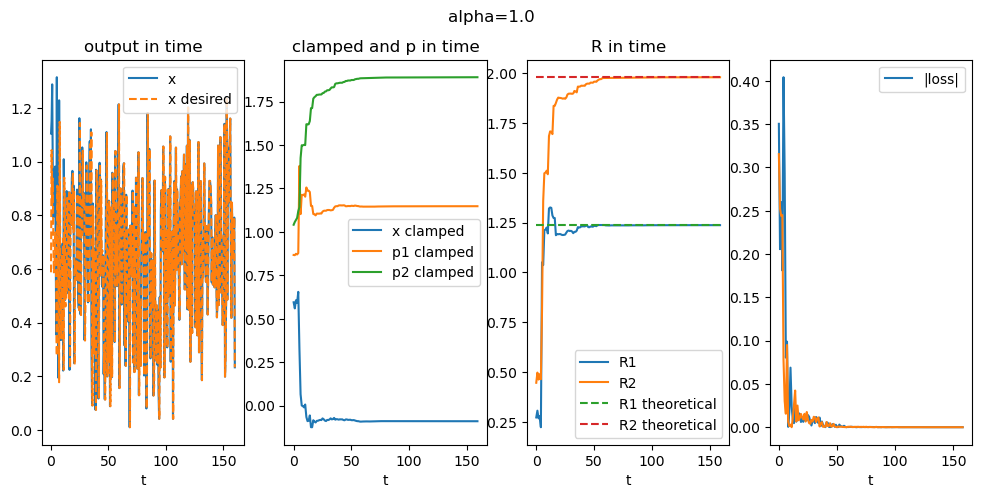

In [12]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

ValueError: x and y must have same first dimension, but have shapes (1,) and (180, 2)

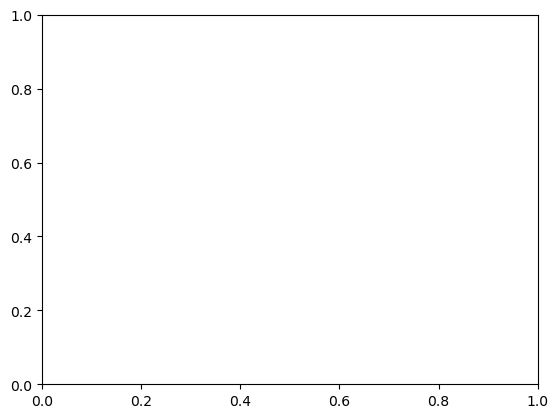

In [6]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

plt.plot(alpha_vec.T, state.out_in_t, '.')
plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")
plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])